<a href="https://colab.research.google.com/github/geunsu-jo/Hands-On-ML/blob/main/textbook_practice/07_ensemble_and_random_forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 앙상블 학습

여러 예측기로 부터 예측 결과를 수집하여, 더 좋은 예측을 얻는 방법. <br>
__배깅__, __부스팅__, __스태킹__ 등이 있다.

샘플 생성

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

## 투표 기반 분류기

__직접 투표기__ : 각 분류기의 다수결 투표로 정해지는 분류기 <br>
__간접 투표기__ : 개별 분류기의 확률을 예측할 수 있다면(__predcit_proba()__ 메서드가 있으면), 클래스 별 예측 확률을 평균을 내어, 가장 높은 클래스를 선택하는 분류기

__직접 투표__

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(solver="newton-cg", random_state=42) # solver ="lbfgs" is default
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", random_state=42)  # if gamma = "scale", 1 / (n_features * X.var()), if gamma = "auto", 1 / n_features

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')

- voting='hard'는 직접 투표(default)
- voting='soft'는 간접 투표

In [3]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=42,
                                                 solver='newton-cg', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,...
                                        

In [4]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


- 각 개별 분류기보다 voting 결과가 더 높음을 알 수 있다.

__간접 투표__

In [5]:
log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')

voting_clf.fit(X_train, y_train)

from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92


## 배깅과 페이스팅

__배깅__ : 중복을 허용하여 리샘플링 후, 샘플마다 같은 알고리즘을 각각 다르게 학습 <br>
__페이스팅__ : 중복을 허용하지 않고 리샘플링 후, 샘플마다 같은 알고리즘을 각각 다르게 학습

분류 문제에서 배깅과 페이스팅은 통계적 최빈값을 클래스로 예측(직접 투표와 같이)하고, 회귀 문제에서는 평균을 계산


### 사이킷런에서 배깅과 페이스팅

사이킷런에서 __BaggingClassifier__(회귀는 BaggingRegressor) 클래스를 사용하여 배깅과 페이스팅 구현가능

In [6]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    max_samples=100, bootstrap=True, random_state=42, n_jobs=-1)

bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

- __n_jobs__ 는 훈련과 예측에 사용할 CPU 코어 수를 지정(-1일 경우 가용한 모든 코어 사용)
- __bootstrap=True__ 이면 배깅이고, False이면 페이스팅

In [7]:
from sklearn.metrics import accuracy_score

tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)

print(accuracy_score(y_test, y_pred_tree))
print(accuracy_score(y_test, y_pred))

0.856
0.904


- 개별 트리보다, 트리를 배깅한 것이 더 높은 예측률

훈련 데이터로부터 학습된 개별 트리와, 배깅의 결정경계 시각화

In [8]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

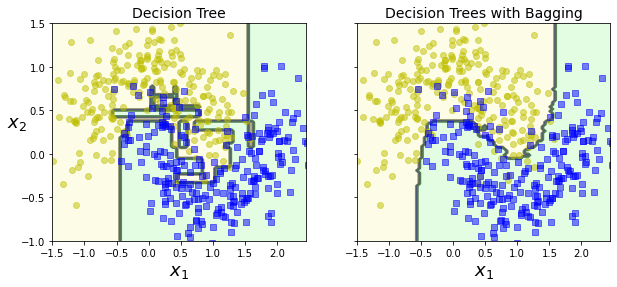

In [9]:
import matplotlib.pyplot as plt
import numpy as np

fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.ylabel("")

plt.show()

### OOB 평가

배깅 방법을 적용할 때, 리샘플링 되지 않은 샘플들로 모델을 평가하는 방법. 중복을 허용하여 리샘플링을 할 때, 대략 63%정도 샘플링되고 남은 37%로 모델을 평가한다. 여기서 나머지 37% 샘플을 oob(out-of-bag) sample이라 부른다.

사이킷런에서 __BaggingClassifer__를 만들때 __oob_score=True__로 지정하면, 자동으로 oob 평가 수행. (개별 분류기의 oob 평가를 평균내어 반환)

In [10]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    bootstrap=True, oob_score=True, random_state=40)
bag_clf.fit(X_train, y_train)

bag_clf.oob_score_

0.9013333333333333

- oob sample을 통해 검증 결과, 90.1%의 정확도를 보임

In [11]:
bag_clf.oob_decision_function_[0:10,]

array([[0.31746032, 0.68253968],
       [0.34117647, 0.65882353],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.08379888, 0.91620112],
       [0.31693989, 0.68306011],
       [0.02923977, 0.97076023],
       [0.97687861, 0.02312139],
       [0.97765363, 0.02234637]])

- 각 훈련 샘플에서 oob 평가를 통해, 클래스의 확률을 반환.
- 예를 들어 첫 샘플이 oob 평가에 사용될 때, 음성일 클래스 확률은 0.31, 양성일 클래스 확률은 0.68

테스트 세트로 평가해보자.

In [12]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.912

## 랜덤 패치와 랜덤 서브스페이스

__랜덤 패치 방식__ : 훈련 샘플과 훈련 특성(feature)를 모두 사용하는 방식 <br>
__랜덤 서브 스페이스__ : 훈련 샘플은 모두 사용하고(중복 허용), 훈련 특성은 일부만 뽑아 사용하는 방식 <br>


특성을 서브 샘플링할 경우 분산은 낮추는 대신, 편향은 증가

## 랜덤 포레스트

배깅과 거의 유사하나, 각 Decision tree에 사용되는 특성을 random하게 선택한다. 즉, 편향을 높이더라도 분산을 더 낮추는 방법. <br>
__max_features="auto"__ 면(default), 트리를 만들때 사용되는 특성은 sqrt(n)개

In [13]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

In [14]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred_rf)

0.912

### 엑스트라 트리

랜덤 포레스트보다 분산을 더 낮추는 극단적인 방법. <br>
각 트리에서 노드를 분할 할 때, 1개의 특성을 무작위적으로 선택한 다음 최적의 임곗값을 구함(랜덤 포레스트는 모든 특성에 대해 최적의 임계값을 구함) <br>
따라서, 랜덤포레스트에 비해 편향은 높으나 분산을 낮추고 계산비용 또한 효율적이다. 랜덤포레스트와 엑스트라 트리중 더 나은 모델을 선택하는 것은 어려우므로 교차 검증을 통해 비교해보는 것이 유일한 방법.

In [15]:
from sklearn.ensemble import ExtraTreesClassifier

ext_clf = ExtraTreesClassifier(n_estimators=500, max_leaf_nodes=16, random_state=42)
ext_clf.fit(X_train, y_train)

y_pred_ext = ext_clf.predict(X_test)

In [16]:
accuracy_score(y_test, y_pred_ext)

0.912

### 특성 중요도

랜덤 포레스트에 있는 모든 트리에 걸쳐서 어떤 특성을 사용한 노드가 평균적으로 불순도를 얼마나 감소시키는지 확인하여 특성의 중요도를 측정한다. DecisionTreeClassifier의 특성 중요도는, 일부 특성을 완전히 배제시킬 수 도 있지만, 랜덤포레스트는 개별 모델에서 특성 선택과정에 무작위성이 주입되므로 모든 특성에 대해 평가할 기회가 주어짐.

In [17]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.11249225099876375
sepal width (cm) 0.02311928828251033
petal length (cm) 0.4410304643639577
petal width (cm) 0.4233579963547682


## 부스팅

약한 학습기를 여러 개 연걸하여 강한 학습기를 만드는 앙상블 방법

## 에이다부스트

이전 모델이 과소적합했던 훈련 샘플의 가중치를 더 높이는 방법

In [40]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=30,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=1,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

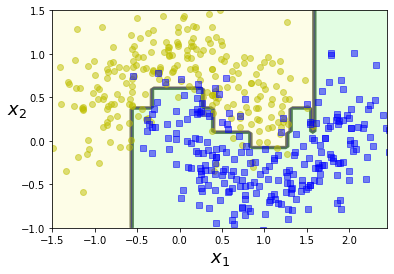

In [41]:
plot_decision_boundary(ada_clf, X, y)